In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


In [2]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [3]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


In [4]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    x_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    x_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [5]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

# def build_model(layers):
#     d = 0.2
#     model = Sequential()
#     model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
#     model.add(Dropout(d))
#     model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
#     model.add(Dropout(d))
#     model.add(Dense(16, init='uniform', activation='relu'))        
#     model.add(Dense(1, init='uniform', activation='linear'))
#     start = time.time()
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#     print("Compilation Time : ", time.time() - start)
#     return model

In [6]:
window = 20
X_train, y_train, X_test, y_test = load_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4648, 20, 6)
y_train (4648,)
X_test (516, 20, 6)
y_test (516,)


In [7]:
model = build_model([X_train.shape[2], window, 100, 1])

Compilation Time :  0.022162199020385742


In [8]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=300,
    validation_split=0.1,
    verbose=2)

Train on 4183 samples, validate on 465 samples
Epoch 1/300
1s - loss: 0.4464 - acc: 0.0000e+00 - val_loss: 0.0171 - val_acc: 0.0000e+00
Epoch 2/300
0s - loss: 0.1410 - acc: 0.0000e+00 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 3/300
0s - loss: 0.1031 - acc: 0.0000e+00 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 4/300
0s - loss: 0.0960 - acc: 0.0000e+00 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 5/300
0s - loss: 0.0923 - acc: 0.0000e+00 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 6/300
0s - loss: 0.0850 - acc: 0.0000e+00 - val_loss: 0.0124 - val_acc: 0.0000e+00
Epoch 7/300
0s - loss: 0.0904 - acc: 0.0000e+00 - val_loss: 0.0154 - val_acc: 0.0000e+00
Epoch 8/300
0s - loss: 0.0714 - acc: 0.0000e+00 - val_loss: 0.0119 - val_acc: 0.0000e+00
Epoch 9/300
0s - loss: 0.0801 - acc: 0.0000e+00 - val_loss: 0.0221 - val_acc: 0.0000e+00
Epoch 10/300
0s - loss: 0.0626 - acc: 0.0000e+00 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 11/300
0s - loss: 0.0603 - acc: 0.0000e+00 - val_loss: 0

In [9]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.09 RMSE)
Test Score: 0.06 MSE (0.24 RMSE)


In [10]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [11]:
# TODO: Scale it back

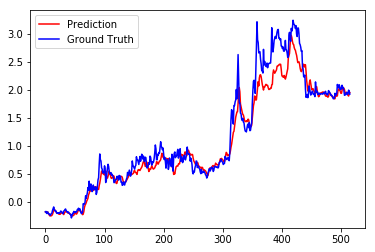

In [12]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()